In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
#顯示小數到第二位
pd.set_option('display.float_format', lambda x:'%.2f'% x)

In [3]:
! pip install lifetimes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 584 kB 5.1 MB/s 


In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from lifetimes import BetaGeoFitter
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions
from lifetimes.plotting import plot_history_alive,plot_cumulative_transactions
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
import warnings
from sklearn.metrics import mean_absolute_percentage_error

warnings.filterwarnings('ignore')

## Calculate the raw recency, frequency, and monetary metrics

In [5]:
sales_data_cp = pd.read_csv('/content/drive/MyDrive/2022數據合作競賽/no_special_day_data.csv')

In [6]:
sales_data_cp

,Unnamed: 0,Unnamed: 0.1,idx,id,order_date,product,sales_price,quantity,department,store,city,district,customer,sex,age_group,Revenue,order_date_notime,special_day
0,0,0,0,41180,2021/7/9 17:32,14095,85,3,13,16,2,54,49986,NaN,1.00,255,2021-07-09,0
1,1,1,1,447222,2021/7/6 23:46,18108,89,1,24,22,1,55,49606,NaN,1.00,89,2021-07-06,0
2,3,3,3,400110,2021/1/12 20:40,23231,75,1,2,0,5,34,85161,NaN,8.00,75,2021-01-12,0
3,4,4,4,396355,2021/7/5 00:03,22272,75,2,5,0,5,34,111291,NaN,8.00,150,2021-07-05,0
4,6,6,6,371766,2020/8/27 10:17,5810,0,1,26,15,8,9,20956,NaN,1.00,0,2020-08-27,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
627509,885742,930527,1030322,365268,2021/6/3 21:21,18490,100,1,21,97,4,0,53435,NaN,1.00,100,2021-06-03,0
627510,885743,930528,1030323,135006,2021/6/7 17:36,1356,64,2,24,97,4,0,53435,NaN,1.00,128,2021-06-07,0
627511,885746,930531,1030326,350379,2021/7/7 16:57,14982,96,1,18,97,4,0,84132,NaN,1.00,96,2021-07-07,0
627512,885747,930532,1030327,288832,2021/6/11 08:27,6133,159,1,26,97,4,0,51318,NaN,1.00,159,2021-06-11,0


In [7]:
sales_data_cp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 627514 entries, 0 to 627513
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         627514 non-null  int64  
 1   Unnamed: 0.1       627514 non-null  int64  
 2   idx                627514 non-null  int64  
 3   id                 627514 non-null  int64  
 4   order_date         627514 non-null  object 
 5   product            627514 non-null  int64  
 6   sales_price        627514 non-null  int64  
 7   quantity           627514 non-null  int64  
 8   department         627514 non-null  int64  
 9   store              627514 non-null  int64  
 10  city               627514 non-null  int64  
 11  district           627514 non-null  int64  
 12  customer           627514 non-null  int64  
 13  sex                81371 non-null   object 
 14  age_group          627514 non-null  float64
 15  Revenue            627514 non-null  int64  
 16  or

In [8]:
df_rfmt = summary_data_from_transaction_data(sales_data_cp, 
                      'customer', 
                      'order_date', 
                      'Revenue',
                      observation_period_end='2021-12-31')

df_rfmt.head()

,frequency,recency,T,monetary_value
customer,,,,
0,0.00,0.00,246.00,0.00
1,0.00,0.00,596.00,0.00
2,7.00,245.00,406.00,101.14
3,2.00,29.00,125.00,99.00
4,0.00,0.00,342.00,0.00


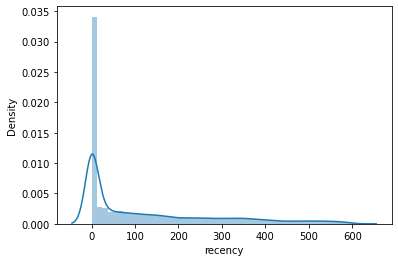

In [9]:
ax = sns.distplot(df_rfmt['recency'])

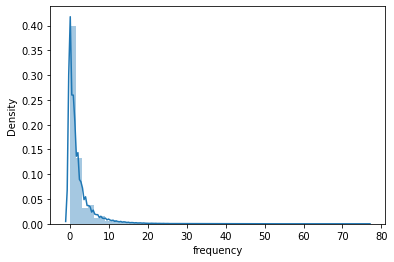

In [10]:
ax = sns.distplot(df_rfmt['frequency'])

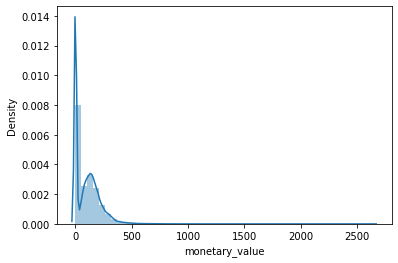

In [11]:
ax = sns.distplot(df_rfmt['monetary_value'])

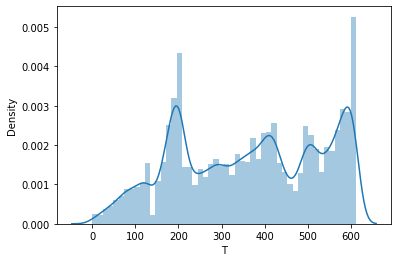

In [ ]:
ax = sns.distplot(df_rfmt['T'])

## **Fit the BG/NBD model**

In [12]:
bgf = BetaGeoFitter(penalizer_coef=0)
bgf.fit(df_rfmt['frequency'], df_rfmt['recency'], df_rfmt['T'])
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.52,0.00,0.51,0.53
alpha,48.19,0.41,47.39,49.00
a,0.94,0.02,0.90,0.98
b,3.43,0.09,3.25,3.61


## Plot the recency and frequency of customers

In [13]:
#axis length
max_freq = int(df_rfmt["frequency"].max())  #quantile(0.95))          
max_T = int(df_rfmt["T"].max())                         
max_rec = int(df_rfmt["recency"].max())  
print(max_freq)

76


In [14]:
# helper function: plot expected number of future purchases a customer with 
#    frequency f and recency r will make in forecast period

def plot_freq_rec(t):
    fig = plt.figure(figsize=(7, 7)) 
    plot_frequency_recency_matrix(
            model = bgf,   
            T = t,  
            max_frequency = max_freq,  
            max_recency = max_rec);

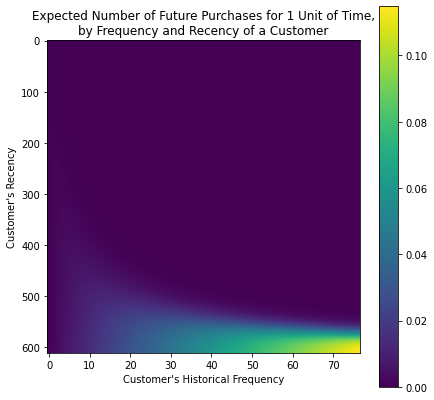

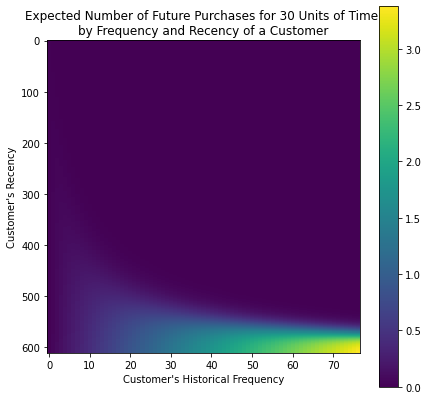

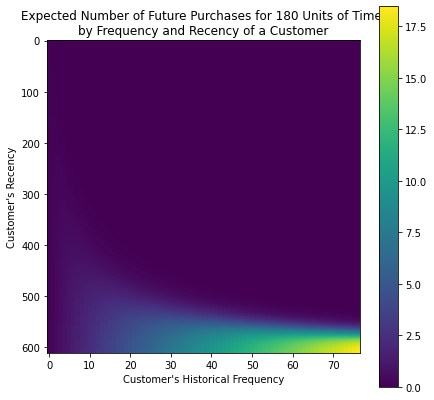

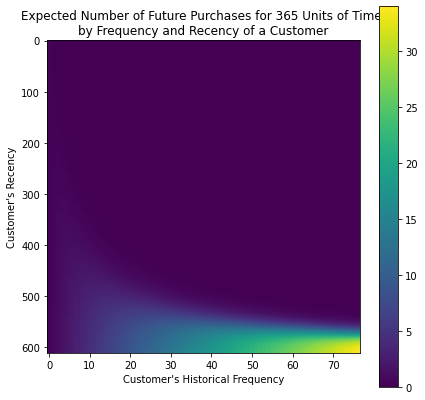

In [15]:
# call plotter function for different forecast periods:
tFC = [1, 30, 180, 365]
_ = [plot_freq_rec(t) for t in tFC]

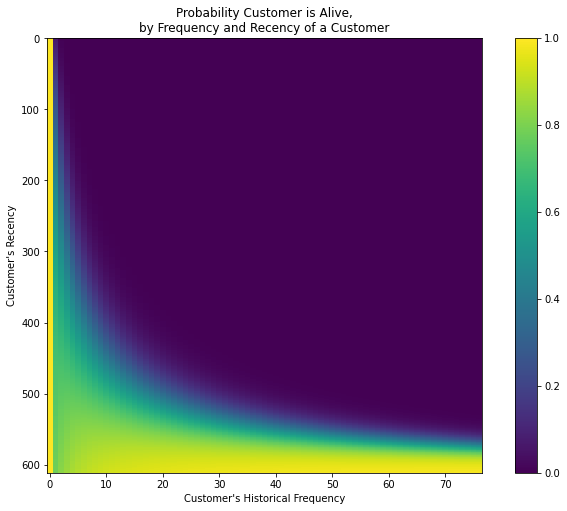

In [16]:
fig = plt.figure(figsize=(12,8))
plot_probability_alive_matrix(bgf)

## Predict the number of orders each customer will make during a time period

In [17]:
# predict each customer's purchases over next t days
def predict_purch(df, t):
        df["predict_purch_" + str(t)] = \
                bgf.conditional_expected_number_of_purchases_up_to_time(t,   
                                              df_rfmt['frequency'], 
                                              df_rfmt['recency'], 
                                              df_rfmt['T'])

In [18]:
# call helper function: predict each customer's purchases over multiple time periods
t_FC = [1, 30, 180, 365]
_ = [predict_purch(df_rfmt, t) for t in t_FC]
pd.options.display.float_format = '{:,.1f}'.format
print("predicted number of purchases for each customer over next t days:")
df_rfmt

predicted number of purchases for each customer over next t days:


,frequency,recency,T,monetary_value,predict_purch_1,predict_purch_30,predict_purch_180,predict_purch_365
customer,,,,,,,,
0,0.0,0.0,246.0,0.0,0.0,0.1,0.3,0.5
1,0.0,0.0,596.0,0.0,0.0,0.0,0.1,0.3
2,7.0,245.0,406.0,101.1,0.0,0.1,0.7,1.3
3,2.0,29.0,125.0,99.0,0.0,0.2,0.8,1.4
4,0.0,0.0,342.0,0.0,0.0,0.0,0.2,0.4
...,...,...,...,...,...,...,...,...
153274,7.0,360.0,407.0,193.0,0.0,0.4,2.1,3.9
153275,1.0,53.0,493.0,64.0,0.0,0.0,0.1,0.2
153276,4.0,68.0,521.0,136.2,0.0,0.0,0.0,0.0


In [19]:
# top 10 customers over next 30 days
print("top 10 customers, by their predicted purchases over next 30 days")
df_rfmt.sort_values(by="predict_purch_30", ascending=False).head(10)

top 10 customers, by their predicted purchases over next 30 days


,frequency,recency,T,monetary_value,predict_purch_1,predict_purch_30,predict_purch_180,predict_purch_365
customer,,,,,,,,
67150,30.0,96.0,98.0,374.9,0.2,5.5,24.6,39.4
26650,76.0,423.0,429.0,206.5,0.2,4.5,24.1,43.2
140935,16.0,44.0,46.0,386.9,0.2,4.4,17.9,27.5
2013,17.0,58.0,61.0,191.4,0.1,4.0,17.1,26.6
23785,55.0,398.0,404.0,256.2,0.1,3.5,18.3,32.7
17935,24.0,148.0,154.0,158.5,0.1,3.2,15.2,25.2
42653,28.0,224.0,224.0,135.4,0.1,2.9,14.5,24.8
80735,25.0,160.0,172.0,149.9,0.1,2.9,13.9,23.3
90595,65.0,595.0,606.0,149.7,0.1,2.8,15.5,28.5


In [20]:
# probability that a customer is alive for each customer in dataframe
prob_alive = bgf.conditional_probability_alive(
        frequency = df_rfmt["frequency"], 
        recency = df_rfmt["recency"], 
        T = df_rfmt["T"])

df_rfmt["prob_alive"] = prob_alive
pd.options.display.float_format = '{:,.2f}'.format
df_rfmt.describe()

,frequency,recency,T,monetary_value,predict_purch_1,predict_purch_30,predict_purch_180,predict_purch_365,prob_alive
count,"129,365.00","129,365.00","129,365.00","129,365.00","129,365.00","129,365.00","129,365.00","129,365.00","129,365.00"
mean,2.24,124.58,363.38,100.12,0.00,0.12,0.63,1.15,0.67
std,3.80,159.11,165.55,109.40,0.01,0.18,0.94,1.68,0.33
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,207.00,0.00,0.00,0.03,0.19,0.36,0.38
50%,1.00,46.00,373.00,87.00,0.00,0.06,0.33,0.62,0.75
75%,3.00,215.00,513.00,164.17,0.00,0.12,0.66,1.19,1.00
max,76.00,610.00,611.00,"2,642.00",0.20,5.52,24.64,43.21,1.00


In [21]:
# show customers who are alive, more than 90% certainty
df_rfmt[df_rfmt["prob_alive"] > 0.9]

,frequency,recency,T,monetary_value,predict_purch_1,predict_purch_30,predict_purch_180,predict_purch_365,prob_alive
customer,,,,,,,,,
0,0.00,0.00,246.00,0.00,0.00,0.05,0.29,0.55,1.00
1,0.00,0.00,596.00,0.00,0.00,0.02,0.14,0.27,1.00
4,0.00,0.00,342.00,0.00,0.00,0.04,0.22,0.43,1.00
9,0.00,0.00,363.00,0.00,0.00,0.04,0.21,0.41,1.00
14,0.00,0.00,173.00,0.00,0.00,0.07,0.38,0.70,1.00
...,...,...,...,...,...,...,...,...,...
153267,23.00,388.00,406.00,189.48,0.05,1.38,7.35,13.21,0.91
153269,0.00,0.00,101.00,0.00,0.00,0.10,0.53,0.96,1.00
153270,0.00,0.00,442.00,0.00,0.00,0.03,0.18,0.35,1.00


## Compare the model’s predictions to the actual data

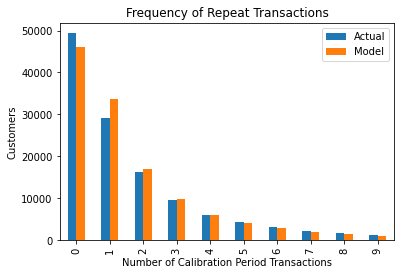

In [22]:
plot_period_transactions(bgf, max_frequency = 10)

## Get predictions for a specific customer

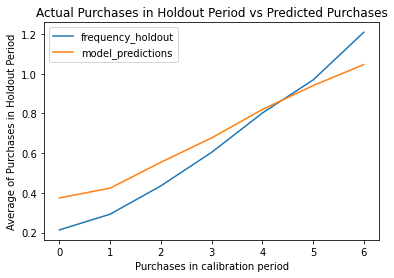

In [23]:
summary_cal_holdout = calibration_and_holdout_data(sales_data_cp, 'customer', 'order_date',calibration_period_end='2021-08-31',observation_period_end='2021-12-31')                                
bgf.fit(summary_cal_holdout['frequency_cal'],   
        summary_cal_holdout['recency_cal'], 
        summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

## Predicting customer lifetime value

In [24]:
df_rfmt[df_rfmt.index==153267]

,frequency,recency,T,monetary_value,predict_purch_1,predict_purch_30,predict_purch_180,predict_purch_365,prob_alive
customer,,,,,,,,,
153267,23.00,388.00,406.00,189.48,0.05,1.38,7.35,13.21,0.91


In [25]:
example_customer_orders = sales_data_cp.loc[sales_data_cp['customer'] == 153267	]
example_customer_orders

,Unnamed: 0,Unnamed: 0.1,idx,id,order_date,product,sales_price,quantity,department,store,city,district,customer,sex,age_group,Revenue,order_date_notime,special_day
577248,818924,863709,955658,376706,2021/10/18 13:15,1919,75,1,24,7,7,1,153267,NaN,6.00,75,2021-10-18,0
577291,818978,863763,955719,169712,2021/8/31 11:47,20666,84,1,24,7,7,1,153267,NaN,6.00,84,2021-08-31,0
577353,819064,863849,955811,540082,2021/12/13 14:37,11715,55,1,24,7,7,1,153267,NaN,6.00,55,2021-12-13,0
577371,819089,863874,955836,557517,2021/4/22 14:49,18351,99,1,24,7,7,1,153267,NaN,6.00,99,2021-04-22,0
577434,819170,863955,955919,376706,2021/10/18 13:15,17633,66,1,24,7,7,1,153267,NaN,6.00,66,2021-10-18,0
577612,819406,864191,956173,313434,2021/3/9 13:26,11329,80,1,24,7,7,1,153267,NaN,6.00,80,2021-03-09,0
577617,819411,864196,956179,518273,2021/1/22 14:36,17039,179,1,26,7,7,1,153267,NaN,6.00,179,2021-01-22,0
577623,819420,864205,956188,148268,2021/11/25 14:32,18676,56,1,24,7,7,1,153267,NaN,6.00,56,2021-11-25,0
577657,819464,864249,956233,303001,2021/11/16 11:11,1329,159,1,24,7,7,1,153267,NaN,6.00,159,2021-11-16,0
577696,819511,864296,956283,327969,2021/2/23 15:21,1631,75,1,24,7,7,1,153267,NaN,6.00,75,2021-02-23,0


In [27]:
sales_data_cp['order_date'] = pd.to_datetime(sales_data_cp['order_date'])

611


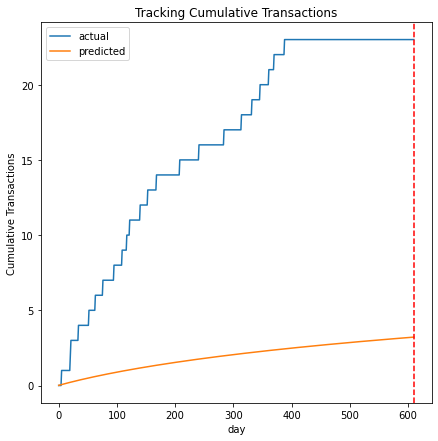

In [28]:
# X selected customer: cumulative transactions
max_date = sales_data_cp["order_date"].max()
min_date = sales_data_cp["order_date"].min()
span_days = (max_date - min_date).days
print(span_days)

fig = plt.figure(figsize=(7, 7)) 
plot_cumulative_transactions(
            model = bgf,  
            transactions = example_customer_orders, 
            datetime_col = "order_date",  
            customer_id_col = "customer",  
            t = span_days,  
            t_cal = span_days);

ConversionError: ignored

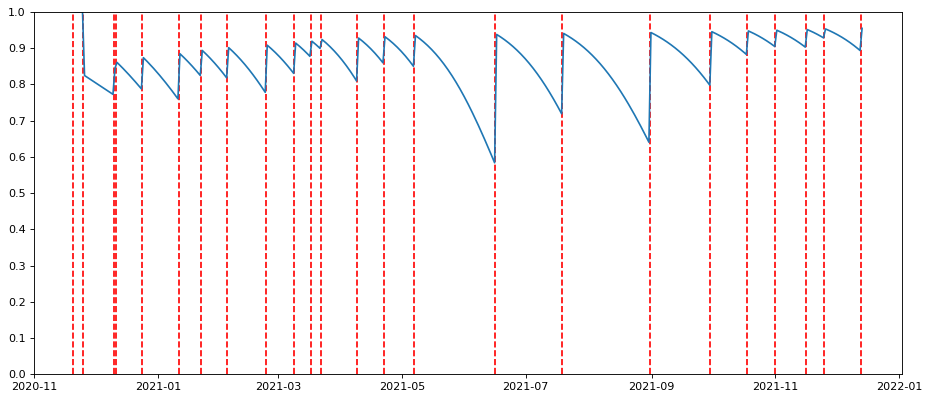

In [29]:
fig = plt.figure(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')

days_since_birth = 118
plot_history_alive(bgf, days_since_birth, example_customer_orders, 'order_date')

In [30]:
returning_customers = df_rfmt[ (df_rfmt['frequency'] > 0) & (df_rfmt['monetary_value'] > 0)]
returning_customers.sort_values(by='monetary_value', ascending=False).head()

,frequency,recency,T,monetary_value,predict_purch_1,predict_purch_30,predict_purch_180,predict_purch_365,prob_alive
customer,,,,,,,,,
65355,1.00,87.00,239.00,"2,642.00",0.00,0.08,0.45,0.83,0.54
41669,1.00,83.00,131.00,"1,667.00",0.01,0.17,0.88,1.56,0.69
113221,1.00,25.00,112.00,"1,584.00",0.00,0.14,0.74,1.29,0.53
98731,1.00,380.00,572.00,"1,425.00",0.00,0.05,0.28,0.54,0.67
29508,1.00,71.00,414.00,"1,416.00",0.00,0.03,0.17,0.33,0.32


In [31]:
returning_customers[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.00,0.02
frequency,0.02,1.00


## Fit the Gamma-Gamma model

In [32]:
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers['frequency'],
        returning_customers['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 78846 subjects, p: 2.59, q: 13.48, v: 795.23>

In [33]:
predicted_monetary = ggf.conditional_expected_average_profit(
        returning_customers['frequency'],
        returning_customers['monetary_value']
)

In [34]:
aov_df = pd.DataFrame(predicted_monetary,columns = ['aov'])
aov_df = aov_df.sort_values(by='aov', ascending=False)

In [36]:
# average order value
aov_df.head(5)

,aov
customer,
104475,898.72
43451,767.27
135609,684.45
85508,653.05
23713,598.85


In [35]:
aov_df.tail(5)

,aov
customer,
88162,89.92
138350,89.87
18676,83.37
43176,82.52
140112,81.45


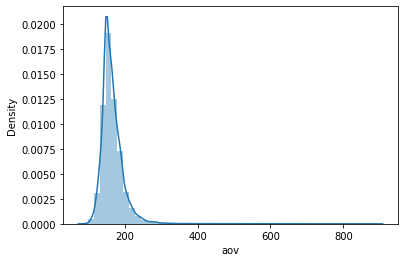

In [37]:
ax = sns.distplot(aov_df['aov'])

In [38]:
# estimate the average transaction value of each customer, based on frequency and monetary value
exp_avg_rev = ggf.conditional_expected_average_profit(
        df_rfmt["frequency"],
        df_rfmt["monetary_value"])

df_rfmt["exp_avg_rev"] = exp_avg_rev
df_rfmt["avg_rev"] = df_rfmt["monetary_value"]
df_rfmt["error_rev"] = df_rfmt["exp_avg_rev"] - df_rfmt["avg_rev"]


mape = mean_absolute_percentage_error(exp_avg_rev, df_rfmt["monetary_value"])
print("MAPE of predicted revenues:", f'{mape:.2f}')

pd.options.display.float_format = '{:,.3f}'.format
df_rfmt.head()

MAPE of predicted revenues: 0.56


,frequency,recency,T,monetary_value,predict_purch_1,predict_purch_30,predict_purch_180,predict_purch_365,prob_alive,exp_avg_rev,avg_rev,error_rev
customer,,,,,,,,,,,,
0,0.000,0.000,246.000,0.000,0.002,0.052,0.291,0.548,1.000,164.732,0.000,164.732
1,0.000,0.000,596.000,0.000,0.001,0.024,0.139,0.271,1.000,164.732,0.000,164.732
2,7.000,245.000,406.000,101.143,0.004,0.132,0.715,1.305,0.272,127.097,101.143,25.954
3,2.000,29.000,125.000,99.000,0.006,0.159,0.803,1.389,0.381,145.477,99.000,46.477
4,0.000,0.000,342.000,0.000,0.001,0.040,0.224,0.428,1.000,164.732,0.000,164.732


In [39]:
df_rfmt.to_csv("/content/drive/MyDrive/2022數據合作競賽/purchase_monetary_predict_no_specialday.csv")